# Introduction

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts.

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input.

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1.


# Imports

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageOps
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import glob
import random
import cv2
from random import shuffle
import imgaug as ia
import imageio
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/img.zip' -d X
!unzip '/content/drive/MyDrive/Colab Notebooks/mask.zip' -d y

# Segmentation

In [ ]:
seq = iaa.Sequential([
      #смещение
      iaa.Affine(translate_px={"x": (-100, 100)}),
      iaa.ClipCBAsToImagePlanes(),
      #контраст
      iaa.LinearContrast((0.75, 1.5)),
      #поворот
      iaa.Affine(rotate=(0, 360)),
      #инверсия
      iaa.Invert(0.5),
  ],
  random_order=True)

# Generators

In [ ]:
def image_generator(files, batch_size = 32, sz = (256, 256)):

  while True:

    #extract a random batch
    batch = np.random.choice(files, size = batch_size)

    #variables for collecting batches of inputs and outputs
    batch_x = []
    batch_y = []


    for f in batch:

        #get the masks. Note that masks are png files
        mask = Image.open(f'y/target/{f[:-4]}.png')
        maks = mask.crop((0, 0, 1024, 701))
        mask = ImageOps.grayscale(mask)
        mask = np.array(mask.resize(sz))


        #preprocess the mask
        #mask[mask >= 2] = 0
        mask[mask != 0 ] = 1
        #batch_y.append(mask)

        #preprocess the raw images
        raw = Image.open(f'X/object/{f}')
        raw = raw.crop((0, 0, 1024, 701))
        raw = raw.resize(sz)
        raw = np.array(raw)


        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        segmap = SegmentationMapsOnImage(mask, shape=mask.shape)
        images_aug_i, segmaps_aug_i = seq(image=raw, segmentation_maps=segmap)

        batch_y.append(segmaps_aug_i.arr)
        batch_x.append(images_aug_i)

    #preprocess a batch of images and masks
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)

In [ ]:
batch_size = 15

all_files = os.listdir('X/object')
shuffle(all_files)

split = int(0.9 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [ ]:
x, y = next(train_generator)

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $y_{true}, y_{pred}$ we evaluate

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [ ]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

# Model

In [ ]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x

  #down sampling
  f = 8
  layers = []

  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64

  #bottleneck
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1

  #upsampling
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1


  #classification
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)

  #model creation
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [mean_iou])

  return model

In [ ]:
model = unet()

# Callbacks

Simple functions to save the model at each epoch and show some predictions

In [ ]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))

        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'X/object/{path}')
        raw = raw.crop((0, 0, 1024, 701))
        raw = np.array(raw.resize((256, 256)))/255.
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        #predict the mask
        pred = model.predict(np.expand_dims(raw, 0))

        #mask post-processing
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1
        msk[msk < 0.5] = 0

        #show the mask and the segmented image
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Training

Epoch 1/10
i= 1 loss= 0.021352339535951614 val_loss= 0.01462652999907732 mean_iou= 0.9461803436279297 val_mean_iou= 0.9588788747787476
1/1 [==============================] - 0s 21ms/step


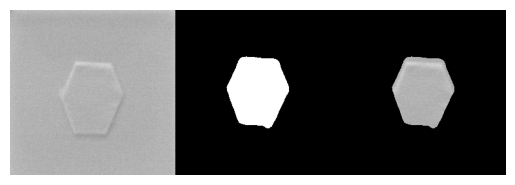

Epoch 2/10
i= 2 loss= 0.02492261864244938 val_loss= 0.02046816796064377 mean_iou= 0.9353230595588684 val_mean_iou= 0.949256956577301
1/1 [==============================] - 0s 29ms/step


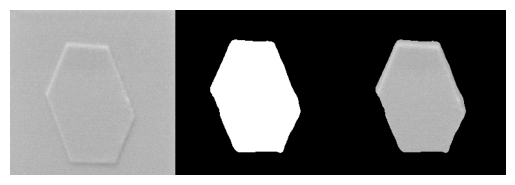

Epoch 3/10
i= 3 loss= 0.01952638290822506 val_loss= 0.016064247116446495 mean_iou= 0.9493370056152344 val_mean_iou= 0.9437652826309204
1/1 [==============================] - 0s 19ms/step


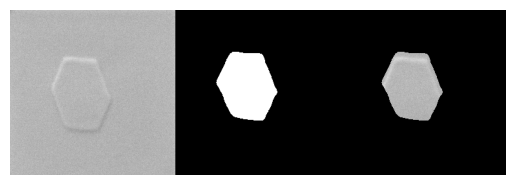

Epoch 4/10
i= 4 loss= 0.017313368618488312 val_loss= 0.013722267001867294 mean_iou= 0.9538626074790955 val_mean_iou= 0.9638223648071289
1/1 [==============================] - 0s 19ms/step


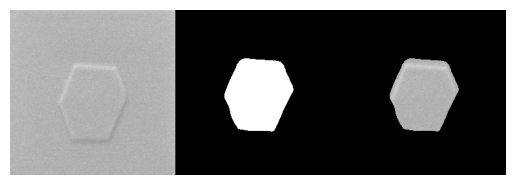

Epoch 5/10
i= 5 loss= 0.015573715791106224 val_loss= 0.015181737020611763 mean_iou= 0.9553579092025757 val_mean_iou= 0.9615476131439209
1/1 [==============================] - 0s 28ms/step


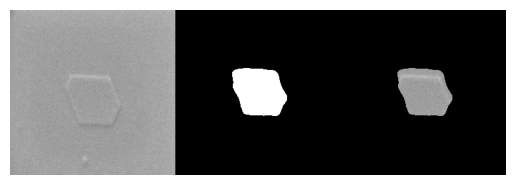

Epoch 6/10
i= 6 loss= 0.017828013747930527 val_loss= 0.01717822439968586 mean_iou= 0.9538508057594299 val_mean_iou= 0.9628228545188904
1/1 [==============================] - 0s 19ms/step


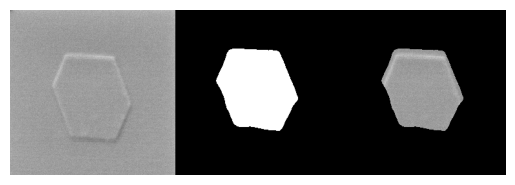

Epoch 7/10
i= 7 loss= 0.015817096456885338 val_loss= 0.015988539904356003 mean_iou= 0.956587553024292 val_mean_iou= 0.9632161259651184
1/1 [==============================] - 0s 19ms/step


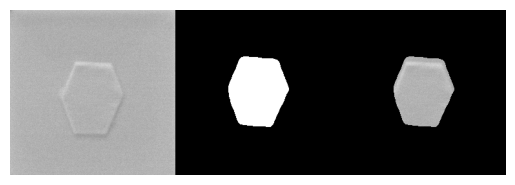

Epoch 8/10
i= 8 loss= 0.015602614730596542 val_loss= 0.014210935682058334 mean_iou= 0.9570679068565369 val_mean_iou= 0.9616149067878723
1/1 [==============================] - 0s 36ms/step


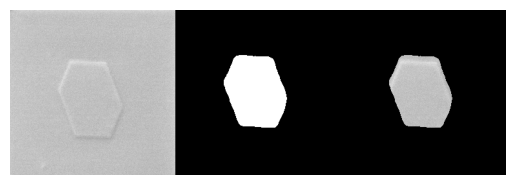

Epoch 9/10
i= 9 loss= 0.016348019242286682 val_loss= 0.014668771997094154 mean_iou= 0.956234335899353 val_mean_iou= 0.9584437608718872
1/1 [==============================] - 0s 21ms/step


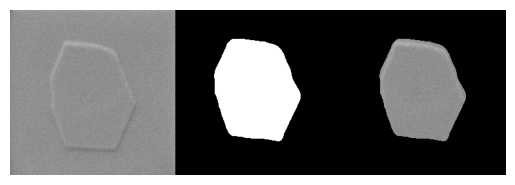

Epoch 10/10
i= 10 loss= 0.020093636587262154 val_loss= 0.01696608029305935 mean_iou= 0.9499697089195251 val_mean_iou= 0.9483346939086914
1/1 [==============================] - 0s 19ms/step


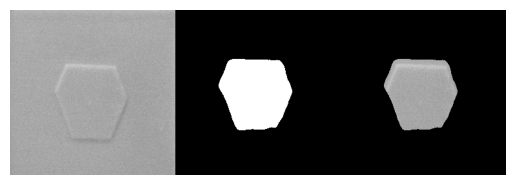

In [ ]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit(train_generator,
                    epochs = 10, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 3)

# Testing

1/1 [==============================] - 0s 21ms/step


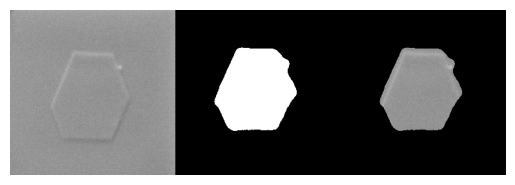

In [ ]:
raw = Image.open('/content/X/object/03W_20um_10 30.tif')
raw = raw.crop((0, 0, 1024, 701))
raw = np.array(raw.resize((256, 256)))/255.
if len(raw.shape) == 2:
  raw = np.stack((raw,)*3, axis=-1)

else:
  raw = raw[:,:,0:3]

#predict the mask
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1
msk[msk < 0.5] = 0

#show the mask and the segmented image
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

In [ ]:
raw = Image.open('/content/X/object/03W_20um_10 30.tif')
raw = raw.crop((0, 0, 1024, 701))
raw = np.array(raw.resize((256, 256)))/255.
if len(raw.shape) == 2:
  raw = np.stack((raw,)*3, axis=-1)

else:
  raw = raw[:,:,0:3]

#predict the mask
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1
msk[msk < 0.5] = 0

1/1 [==============================] - 0s 27ms/step
